In [60]:
from queue import PriorityQueue
from itertools import combinations

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from icecream import ic

## Objective
Intent- Using A* algorithm and TSP to determine shortest tour around all towns of Tamil Nadu

## Loading Dataframe 

In [64]:
# distances are uploaded in a csv file
df=pd.read_csv("distances.csv",usecols=["name","x","y"],index_col="name")
df.head(10)

,x,y
name,,
Chennai,810,100
Trichy,504,511
Madurai,375,716
Toothukudi,370,921
Salem,439,380
Nammakal,400,460
Thiruvannamalai,569,248
Coimbatore,171,526
Nilgiris,129,419


In [63]:
for i in df.index:
    print(i)

Chennai
Trichy
Madurai
Toothukudi
Salem
Nammakal
Thiruvannamalai
Coimbatore
Nilgiris
Erode
Theni
Thanjavur
Sivaganga
Thirunalveli
Kanyakumari
Tenkasi
Tiruppur
Cuddalore
Perambalur
Pudukkottai
Karur
Krishnagiri
Ranipet
Kanchipuram
Tiruvallur
Chengalpattu
Ramanathapuram
Virudhunagar
Vellore
Dindigul
Tiruvarur
Nagapattnam
Mayiladutharai
Ariyalur
Dharmapuri
Villupuram
Kallakurichi
Tirupattur


## Computation of Distance Matrix (Using Euclidean Distance)

## Map of Tamil Nadu using matplotlib

In [5]:
plt.ion()
# display img first
map_width=860
map_height=1109
map_dimensions=[0,map_width,0,map_height]
map_ratio=map_height/map_width


#PLOTTING GRAPH=========================================

def create_new_figure():
    figure,ax=plt.subplots(figsize=(9,9*map_ratio))
    ax.set_axis_off()
    return figure,ax
def add_subplot_background(figure,ax):
    #Background ax-----------------------------
    im = plt.imread("map_unlabelled.png")
    subplot_bgimage=ax.imshow(im,extent=map_dimensions)

#figure,ax=create_new_figure()
#add_subplot_background(figure,ax)

In [6]:
def add_subplot_scatterplot_citypoints(figure,ax):    
    #Another ax for scatterplot
    df["map_x"]=df["x"]
    df["map_y"]=df["y"].apply(lambda x:map_height-x)


    X=df["map_x"]
    Y=df["map_y"]
    labels=df.index

    mappoints=ax.scatter(X,Y,marker=".")
    #mappoints.axis(False)
#add_subplot_scatterplot_citypoints(figure,ax)

In [7]:
def add_subplot_label_cities(figure,ax,df):
    
    X=df["map_x"]
    Y=df["map_y"]
    labels=df.index
    for i, label in enumerate(labels):
        ax.text(X.iloc[i], Y.iloc[i], label, fontsize=8, ha='center', va='center',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2')
                 )

#add_subplot_label_cities(figure,ax,df)
#figure

### Final labelled map of Tamil Nadu

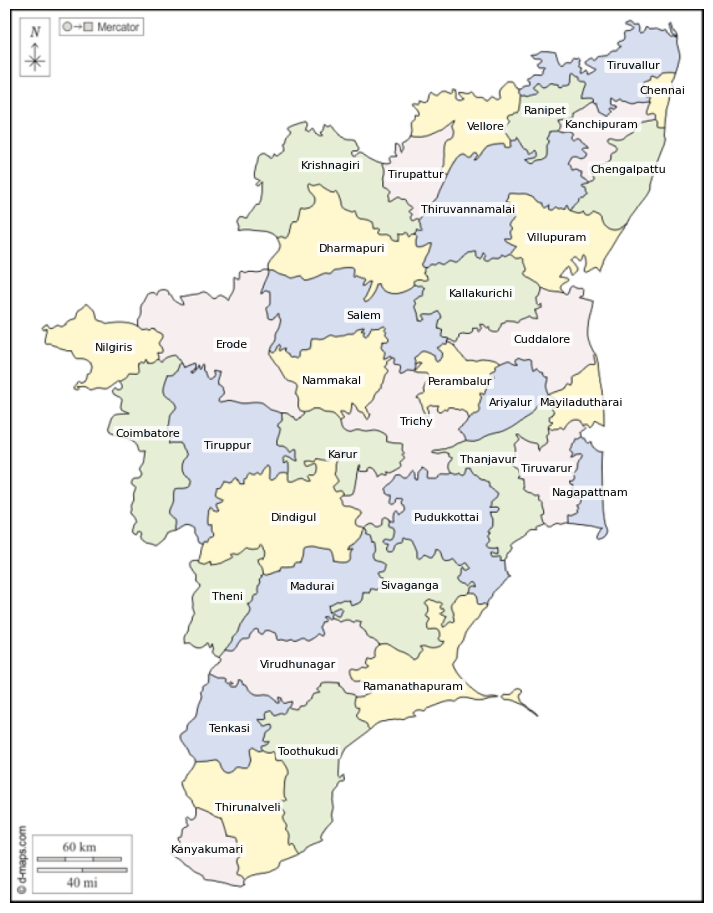

In [8]:
def restore_img():
    figure,ax=create_new_figure()
    add_subplot_background(figure,ax)
    add_subplot_scatterplot_citypoints(figure,ax)
    add_subplot_label_cities(figure,ax,df)
    return figure,ax

figure,ax=restore_img()


In [23]:
def add_plot_travel(figure,ax,*,source_name,dest_name):
    source=df.loc[source_name]
    dest=df.loc[dest_name]
    if (source.empty or dest.empty):
        print("check city name again")
        return
    X=[source['map_x'],dest['map_x']]
    Y=[source['map_y'],dest['map_y']]

    ax.plot(X,Y)

    x1=source["map_x"]
    x2=dest["map_x"]
    y1=source["map_y"]
    y2=dest["map_y"]
    slope=(y2-y1)/(x2-x1+.000001)

    text_x=(x1+x2)/2 -10
    text_y=(y1+y2)/2 -10

    label=str(int(source[dest.name]))
    #ic(f"The distance bw {source_name} and {dest_name} is {label}")

    ax.text(text_x, text_y, label, fontsize=6,ha='center', va='bottom',rotation=np.degrees(np.arctan(slope)),
           bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))
    
    
#add_plot_travel(figure,ax,source_name="Madurai",dest_name="Trichy")

## Travelling Salesman Solver

In [24]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

def solve_tsp(distance_matrix):
    manager = pywrapcp.RoutingIndexManager(len(distance_matrix), 1, 0)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        # Convert routing variable indices to distance matrix indices.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        # Retrieve the distance, handling infinity properly.
        distance = distance_matrix[from_node][to_node]
        if np.isinf(distance):
            return routing_model.registered_penalty()  # Large penalty for infeasible paths
        return int(distance)  # Convert float to int if necessar
        
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

    solution = routing.Solve()
    if solution:
        index = routing.Start(0)
        plan_output = [] #'Route:\n'
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output.append(manager.IndexToNode(index)) #+= f' {manager.IndexToNode(index)} ->'
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
        plan_output.append(manager.IndexToNode(index)) #+= f'{manager.IndexToNode(index)}\n'
    return plan_output,route_distance

In [25]:
plan_output,route_distance=solve_tsp(distance_matrix=distance_matrix.to_numpy())
print(plan_output)
print(f'Route distance: {route_distance}')
plan_output_cities=[dict(enumerate(df.index))[i]for i in plan_output]
print(plan_output_cities)

[0, 24, 23, 22, 28, 6, 37, 21, 34, 4, 5, 9, 8, 7, 16, 10, 27, 15, 14, 13, 3, 26, 12, 2, 29, 20, 1, 18, 33, 11, 19, 30, 31, 32, 17, 36, 35, 25, 0]
Route distance: 2506
['Chennai', 'Tiruvallur', 'Kanchipuram', 'Ranipet', 'Vellore', 'Thiruvannamalai', 'Tirupattur', 'Krishnagiri', 'Dharmapuri', 'Salem', 'Nammakal', 'Erode', 'Nilgiris', 'Coimbatore', 'Tiruppur', 'Theni', 'Virudhunagar', 'Tenkasi', 'Kanyakumari', 'Thirunalveli', 'Toothukudi', 'Ramanathapuram', 'Sivaganga', 'Madurai', 'Dindigul', 'Karur', 'Trichy', 'Perambalur', 'Ariyalur', 'Thanjavur', 'Pudukkottai', 'Tiruvarur', 'Nagapattnam', 'Mayiladutharai', 'Cuddalore', 'Kallakurichi', 'Villupuram', 'Chengalpattu', 'Chennai']


## Result

In [26]:
def plot_tsp_answer_onto_map(plan_output_cities):
    figure,ax=restore_img()
    for i in range(len(plan_output_cities)-1):
        city1=plan_output_cities[i]
        city2=plan_output_cities[i+1]
        add_plot_travel(figure,ax,source_name=city1,dest_name=city2)


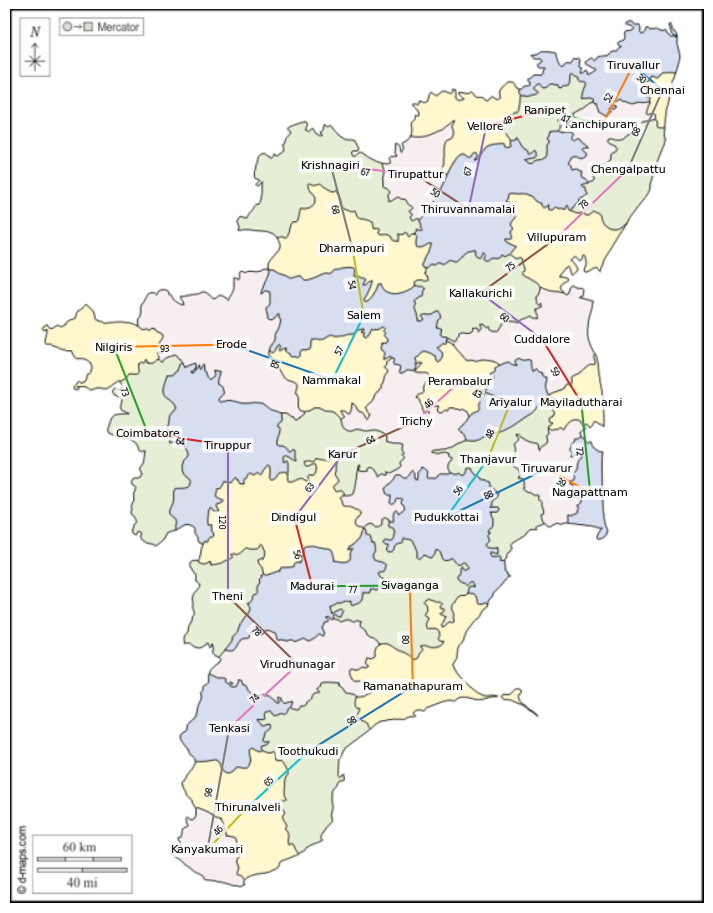

In [27]:
plot_tsp_answer_onto_map(plan_output_cities=plan_output_cities)

In [28]:
print(f"The total distance travelled is {route_distance}")

The total distance travelled is 2506


## Working on A* Algorithm

In [ ]:
def calculate_heuristic_distance(source,dest):
    x1,y1=source[["x","y"]]
    x2,y2=dest[["x","y"]]
    d=((x2-x1)**2+(y2-y1)**2)**.5
    return d


In [65]:
'''
def recalculate_heuristics(df,dest_name):
    dest=df.loc[dest_name]
    df["h(x)"]=df.apply(calculate_heuristic_distance,args=(dest,),axis=1)
    display(df["h(x)"])
'''


'\ndef recalculate_heuristics(df,dest_name):\n    dest=df.loc[dest_name]\n    df["h(x)"]=df.apply(calculate_heuristic_distance,args=(dest,),axis=1)\n    display(df["h(x)"])\n'

In [ ]:
      
def determine_shortest_path_bw_2_cities(self,source_name,dest_name):
    source=self.df[self.df["name"]==source_name]
    dest=self.df[self.df["name"]==dest_name]
    if (source.empty or dest.empty):
        print("check city name again")
        return


    x1=source["map_x"].values[0]
    x2=dest["map_x"].values[0]
    y1=source["map_y"].values[0]
    y2=dest["map_y"].values[0]
    slope=(y2-y1)/(x2-x1)

    text_x=(x1+x2)/2 -10
    ic(text_x)
    text_y=(y1+y2)/2 -10
    ic(text_y)
    label=str(int(g.matrix.loc[source["name"]][dest["name"]].values[0][0]))
    ic(f"The distance bw {source_name} and {dest_name} is {label}")

    plt.text(text_x, text_y, label, fontsize=10,ha='center', va='center',rotation=np.degrees(np.arctan(slope)),
            bbox=dict(facecolor='white', alpha=0.90, edgecolor='none', boxstyle='round,pad=0.1'))

    self.update_all_heuristics(dest)


In [ ]:
#A* algorithm
